In [1]:
import os
import tensorflow as tf
import tensorflow
from tqdm.keras import TqdmCallback
from glob import glob
import scipy.misc
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, MaxPooling2D
from tensorflow.keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, PReLU, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from numpy import random
from sklearn.model_selection import KFold
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow.keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from skimage.metrics import structural_similarity as ssim
tf.debugging.set_log_device_placement(True)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print(tf.test.is_built_with_cuda())

True


In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
from google.colab import drive
drive .mount('/content/drive')

Mounted at /content/drive


In [7]:
img_size = 400
#Function to iterate through all the images
def datenladen(path):
    data = []
    img_path={}
    for i in range (400):
        try:
            
            img= cv2.imread(path[i], cv2.IMREAD_GRAYSCALE)
            img_last = cv2.resize(img, (img_size, img_size))
            data.append([img_last])
            img_path[i] = path[i]
        except Exception as e:
            pass
    
    return data,img_path

In [8]:
data = glob('drive/MyDrive/ColabNotebooks/input/*')

In [9]:
data = sorted(data)

In [10]:
altered,img_path_altered = datenladen(data)

In [11]:
img_path_altered

{0: 'drive/MyDrive/ColabNotebooks/input/5001.jpg',
 1: 'drive/MyDrive/ColabNotebooks/input/5002.jpg',
 2: 'drive/MyDrive/ColabNotebooks/input/5003.jpg',
 3: 'drive/MyDrive/ColabNotebooks/input/5004.jpg',
 4: 'drive/MyDrive/ColabNotebooks/input/5005.jpg',
 5: 'drive/MyDrive/ColabNotebooks/input/5006.jpg',
 6: 'drive/MyDrive/ColabNotebooks/input/5007.jpg',
 7: 'drive/MyDrive/ColabNotebooks/input/5008.jpg',
 8: 'drive/MyDrive/ColabNotebooks/input/5009.jpg',
 9: 'drive/MyDrive/ColabNotebooks/input/5010.jpg',
 10: 'drive/MyDrive/ColabNotebooks/input/5011.jpg',
 11: 'drive/MyDrive/ColabNotebooks/input/5012.jpg',
 12: 'drive/MyDrive/ColabNotebooks/input/5013.jpg',
 13: 'drive/MyDrive/ColabNotebooks/input/5014.jpg',
 14: 'drive/MyDrive/ColabNotebooks/input/5015.jpg',
 15: 'drive/MyDrive/ColabNotebooks/input/5016.jpg',
 16: 'drive/MyDrive/ColabNotebooks/input/5017.jpg',
 17: 'drive/MyDrive/ColabNotebooks/input/5018.jpg',
 18: 'drive/MyDrive/ColabNotebooks/input/5019.jpg',
 19: 'drive/MyDrive/Co

In [12]:
X = np.array(altered).reshape(-1, img_size, img_size, 1)
X = X / 255.0
del altered
del data

In [13]:
real_path = glob('drive/MyDrive/ColabNotebooks/real_input/*')

In [14]:
real_path = sorted(real_path)

In [15]:
real,img_path_real = datenladen(real_path)
y_real= np.array(real).reshape(-1, img_size, img_size, 1)
y_real = y_real / 255.0
del real

In [16]:
img_path_real

{0: 'drive/MyDrive/ColabNotebooks/real_input/5001.jpg',
 1: 'drive/MyDrive/ColabNotebooks/real_input/5002.jpg',
 2: 'drive/MyDrive/ColabNotebooks/real_input/5003.jpg',
 3: 'drive/MyDrive/ColabNotebooks/real_input/5004.jpg',
 4: 'drive/MyDrive/ColabNotebooks/real_input/5005.jpg',
 5: 'drive/MyDrive/ColabNotebooks/real_input/5006.jpg',
 6: 'drive/MyDrive/ColabNotebooks/real_input/5007.jpg',
 7: 'drive/MyDrive/ColabNotebooks/real_input/5008.jpg',
 8: 'drive/MyDrive/ColabNotebooks/real_input/5009.jpg',
 9: 'drive/MyDrive/ColabNotebooks/real_input/5010.jpg',
 10: 'drive/MyDrive/ColabNotebooks/real_input/5011.jpg',
 11: 'drive/MyDrive/ColabNotebooks/real_input/5012.jpg',
 12: 'drive/MyDrive/ColabNotebooks/real_input/5013.jpg',
 13: 'drive/MyDrive/ColabNotebooks/real_input/5014.jpg',
 14: 'drive/MyDrive/ColabNotebooks/real_input/5015.jpg',
 15: 'drive/MyDrive/ColabNotebooks/real_input/5016.jpg',
 16: 'drive/MyDrive/ColabNotebooks/real_input/5017.jpg',
 17: 'drive/MyDrive/ColabNotebooks/real_i

In [17]:
batch_size = 64
epochs = 200
z = 1
x, y = img_size, img_size
input= Input(shape = (x, y, z))

In [18]:
def model(input):
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    model = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return model

In [19]:
model = Model(input, model(input))
model.compile(loss='mean_squared_error', optimizer = Adam())

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/ta

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856 

In [21]:
from random import sample
def create_train_test(X,y_real,img_path_real,test_size=0.2):
    valid_path_true = []
    valid_path_index = []
    number_of_test_index=int(test_size*100)
    list_of_number = list(range(len(X)))
    test_index = sample(list_of_number, number_of_test_index)
    train_index = list(set(list(range(len(X)))) - set(test_index))
    X_train = np.take(X, train_index, axis=0)
    X_valid = np.take(X, test_index, axis=0)
    y_train = np.take(y_real, train_index, axis=0)
    y_valid = np.take(y_real, test_index, axis=0)
    for i in test_index:
        valid_path_true.append(img_path_real[i])
        valid_path_index.append(i)
    return X_train,y_train,X_valid,y_valid,valid_path_true,valid_path_index

In [22]:
X_train,y_train,X_valid,y_valid,valid_path_true,valid_path_index = create_train_test(X,y_real,img_path_real)

In [23]:
model_result = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_valid, y_valid))

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1162 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
2/2 [==============================] - 2s 454ms/step - loss: 0.0813 - val_loss: 0.0791
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 16/200
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_988 in device /job:localhost/replica:0/task:0/device:GPU:0
1/2 [

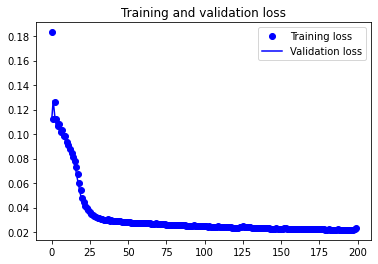

In [24]:
loss = model_result.history['loss']
val_loss = model_result.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
pred = model.predict(X_valid)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

In [32]:
pred[0]

array([[[0.940875  ],
        [0.98972696],
        [0.9954756 ],
        ...,
        [0.9944028 ],
        [0.98937047],
        [0.9488402 ]],

       [[0.99240327],
        [0.99974555],
        [0.999944  ],
        ...,
        [0.9998789 ],
        [0.9995664 ],
        [0.9915624 ]],

       [[0.9936434 ],
        [0.99984646],
        [0.99997354],
        ...,
        [0.99996305],
        [0.99983406],
        [0.99561274]],

       ...,

       [[0.9859724 ],
        [0.9991179 ],
        [0.9998142 ],
        ...,
        [0.9994993 ],
        [0.99852365],
        [0.98462415]],

       [[0.9806394 ],
        [0.9982622 ],
        [0.99951684],
        ...,
        [0.9988285 ],
        [0.99690187],
        [0.97186035]],

       [[0.9217101 ],
        [0.9810207 ],
        [0.99050915],
        ...,
        [0.9888453 ],
        [0.9787663 ],
        [0.9172607 ]]], dtype=float32)

In [47]:
def create_path_for_prediction(pred,valid_path_index):
    assert len(pred)==len(X_valid)
    pred_path = []
    
    for i in range(len(pred)):
        data = pred[i].astype(np.float64) 
        data = 255 * data # Now scale by 255
        img_ui = data.astype(np.uint8)
        img = Image.fromarray(img_ui[:,:,0])
        img_name = f"drive//MyDrive//ColabNotebooks//valid_data//{valid_path_index[i]}_pred.png"
        pred_path.append(img_name)
        img.save(img_name)
    return pred_path
pred_path = create_path_for_prediction(pred,valid_path_index)

In [48]:
pred_path

['drive//MyDrive//ColabNotebooks//valid_data//14_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//51_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//1_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//47_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//74_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//68_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//88_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//70_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//61_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//84_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//7_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//40_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//96_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//31_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//63_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_data//39_pred.png',
 'drive//MyDrive//ColabNotebooks//valid_da

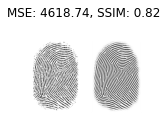

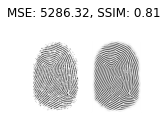

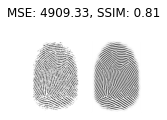

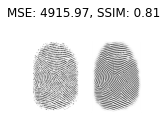

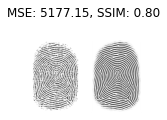

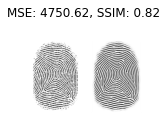

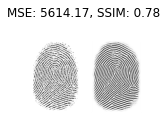

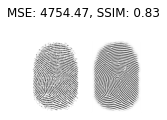

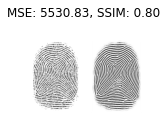

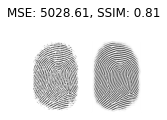

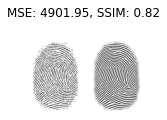

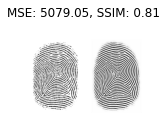

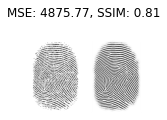

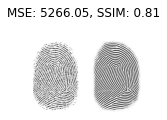

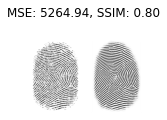

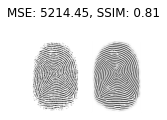

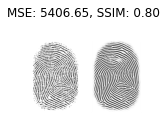

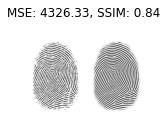

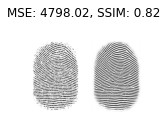

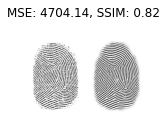

Mean MSE: 5021.178860454545
Mean Similarity: 0.8114529026128541


In [54]:
def create_similarity_score(valid_path_true,pred_path):
    assert len(valid_path_true) == len(pred_path)
    
    total_mse = []
    total_similarity = []
    for i in range(len(valid_path_true)):
        valid = cv2.imread(valid_path_true[i])
        pred = cv2.imread(pred_path[i])
        pred = cv2.resize(pred, (275,400))
        err = np.sum((valid.astype("float") - pred.astype("float")) ** 2)
        err /= float(valid.shape[0] * valid.shape[1])
        
        valid = cv2.cvtColor(valid, cv2.COLOR_BGR2GRAY)
        pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

        m = err
        total_mse.append(m)
        s = ssim(valid, pred)
        total_similarity.append(s)
        title = f"{i}.th index"
        fig = plt.figure(title,figsize=(2, 2))
        plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(valid, cmap = plt.cm.gray)
        plt.axis("off")

        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(pred, cmap = plt.cm.gray)
        plt.axis("off")
        plt.show()


    print('Mean MSE:',sum(total_mse)/len(total_mse))
    print('Mean Similarity:',sum(total_similarity)/len(total_similarity))
    return total_mse,total_similarity
mse_score,similarity_score = create_similarity_score(valid_path_true,pred_path)

In [56]:
assert len(list(range(1,len(mse_score)+1))) == len(mse_score), 'False'

In [57]:
length_of_valid_data = range(1,len(mse_score)+1)
score_data = pd.DataFrame(
    {'index_of_image': length_of_valid_data,
     'mse_score': mse_score,
     'similarity': similarity_score
    })


In [58]:
score_data.head()

index_of_image    mse_score  similarity
0               1  4618.739564    0.820321
1               2  5286.320264    0.809864
2               3  4909.329027    0.811684
3               4  4915.968600    0.809502
4               5  5177.149473    0.803478

In [59]:
score_data.to_excel('validation_score.xlsx')

Test Images


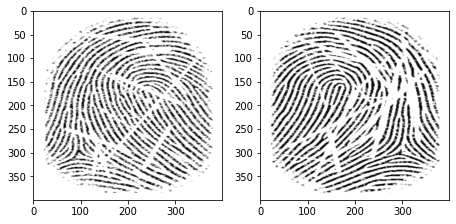

Reconstruction of Test Images


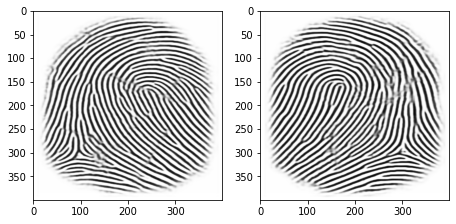

In [60]:
plt.figure(figsize=(40, 40))
print("Test Images")
for i in range(2):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_valid[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(40, 40))
print("Reconstruction of Test Images")
for i in range(2):
    plt.subplot(1, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap="gray")  
plt.show()

Testbilder


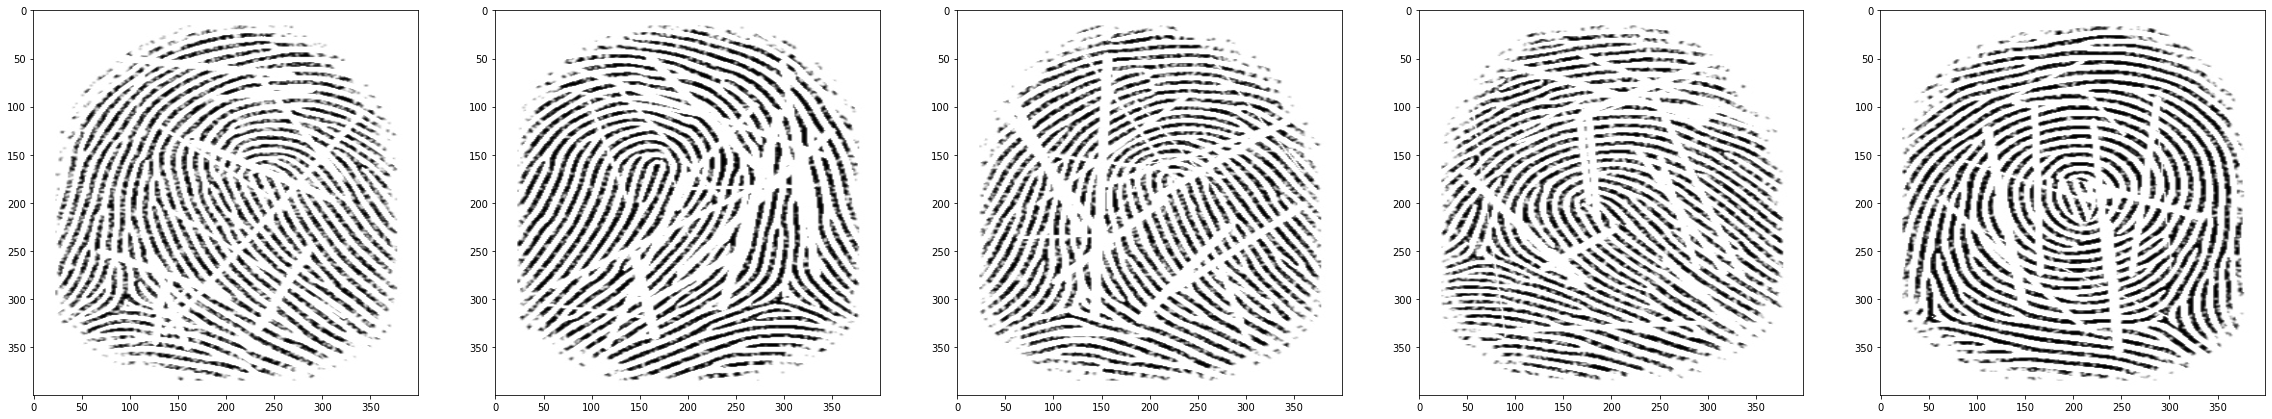

Testlabel


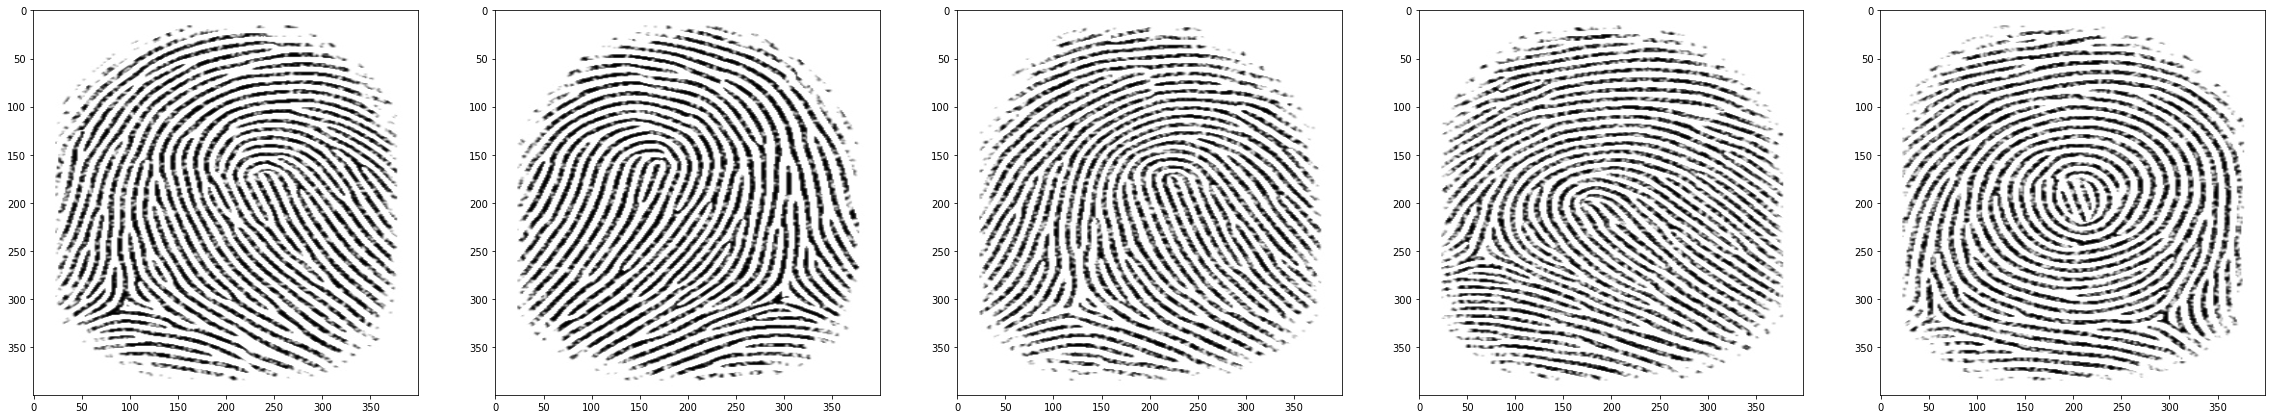

Rekonstruktion von Testbildern


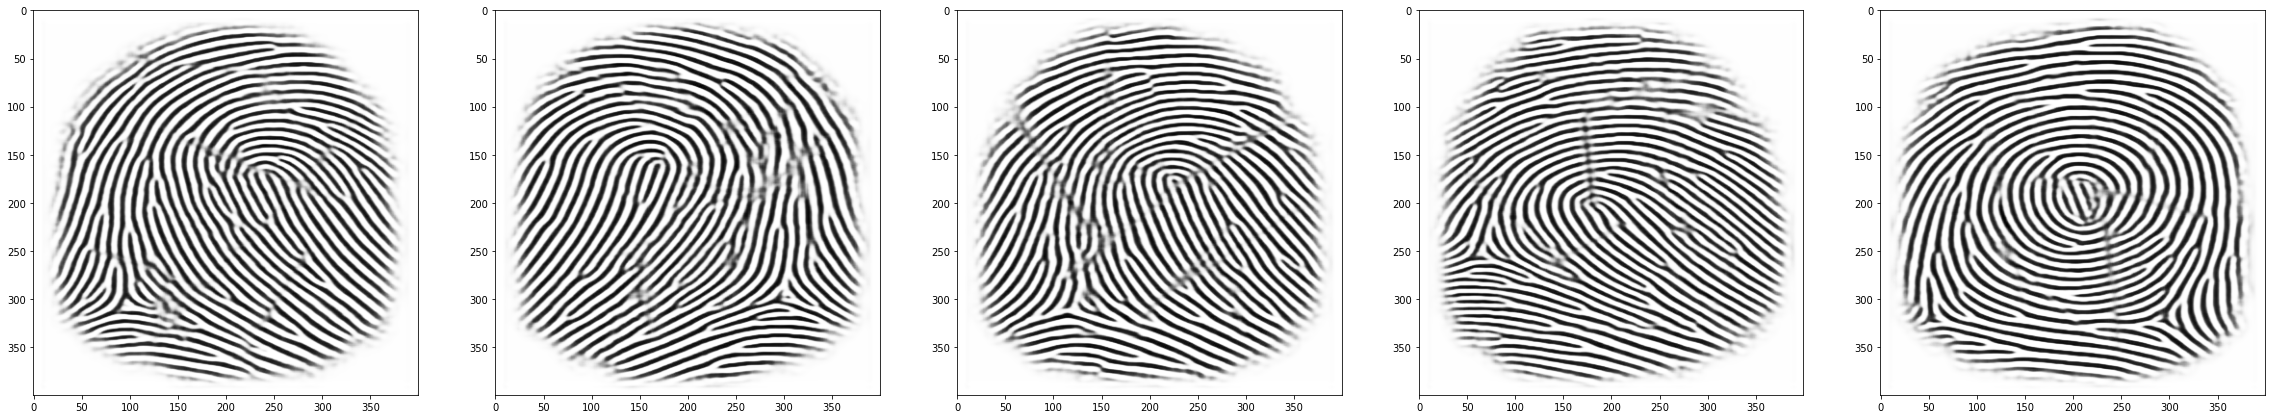

In [61]:
plt.figure(figsize=(40, 40))
print("Testbilder")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_valid[i, ..., 0], cmap='gray')
plt.show()  
plt.figure(figsize=(40, 40))
print("Testlabel")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_valid[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(40, 40))
print("Rekonstruktion von Testbildern")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap="gray")  
plt.show()